In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [3]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

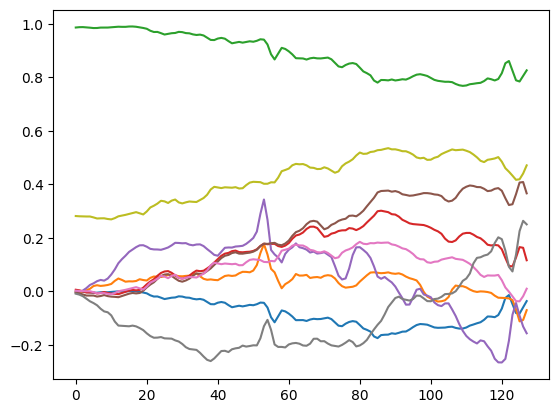

In [5]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [6]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           24704 

In [ ]:
tf.keras.utils.plot_model(model)

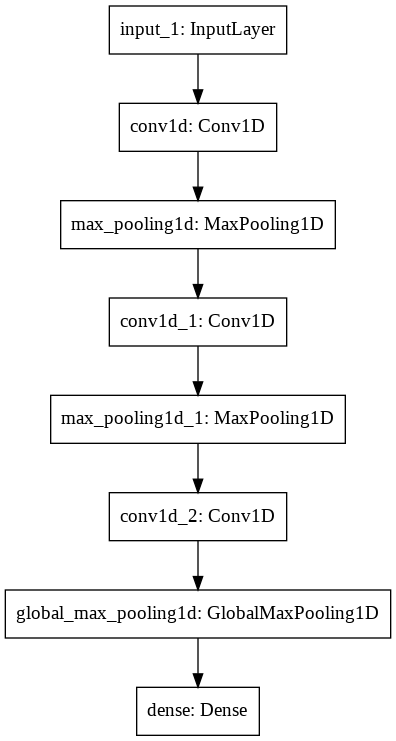

In [8]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

In [9]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [10]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/15
230/230 [==============================] - 7s 7ms/step - loss: 0.3909 - accuracy: 0.8662 - val_loss: 0.2395 - val_accuracy: 0.9036
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1247 - accuracy: 0.9520 - val_loss: 0.2609 - val_accuracy: 0.9091
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1094 - accuracy: 0.9543 - val_loss: 0.2047 - val_accuracy: 0.9125
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0992 - accuracy: 0.9593 - val_loss: 0.2064 - val_accuracy: 0.9155
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0966 - accuracy: 0.9595 - val_loss: 0.2218 - val_accuracy: 0.9101
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0909 - accuracy: 0.9607 - val_loss: 0.2017 - val_accuracy: 0.9097
Epoch 7/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0873 - accuracy: 0.9626 - val_loss: 0.2163 - val_accuracy: 0.9165
Epoch 

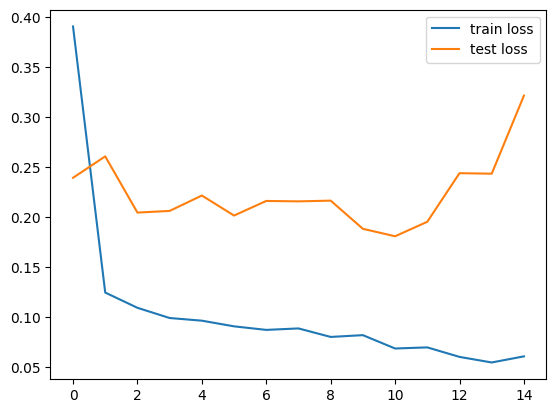

In [11]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

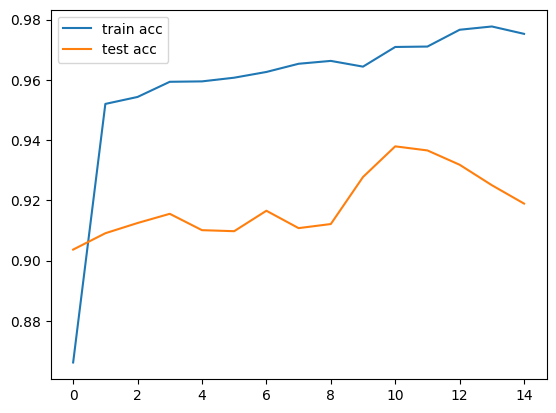

In [12]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [13]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [14]:
# make predictions
Ptest = best_model.predict(Xtest)

93/93 [==============================] - 0s 3ms/step


In [15]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9379029521547336

In [17]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [19]:
D_feat = feat_train.shape[1]

In [20]:
# Combined Model

# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

In [ ]:
tf.keras.utils.plot_model(model)

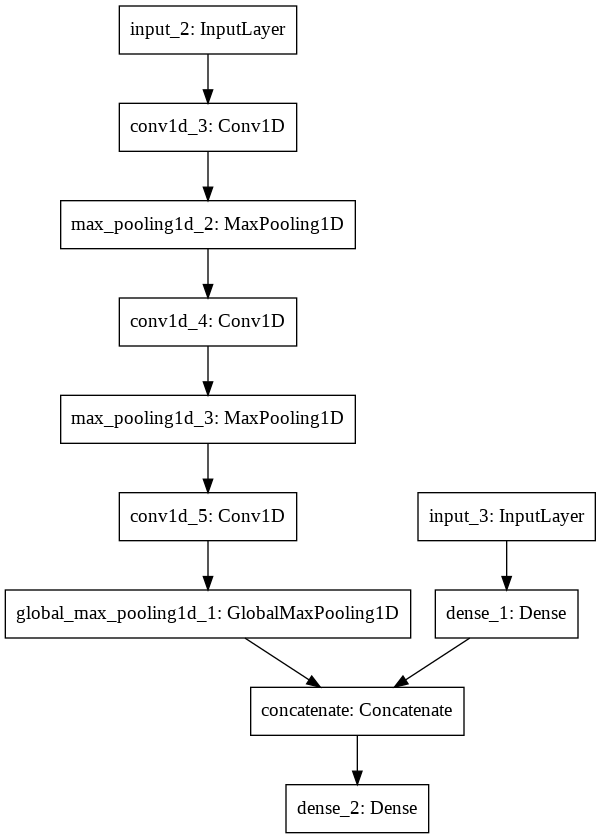

In [21]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [22]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [23]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point3],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 2s 8ms/step - loss: 0.2382 - accuracy: 0.9117 - val_loss: 0.1576 - val_accuracy: 0.9348
Epoch 2/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9694 - val_loss: 0.2103 - val_accuracy: 0.9223
Epoch 3/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0535 - accuracy: 0.9788 - val_loss: 0.1310 - val_accuracy: 0.9525
Epoch 4/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0474 - accuracy: 0.9823 - val_loss: 0.1295 - val_accuracy: 0.9576
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0386 - accuracy: 0.9849 - val_loss: 0.1280 - val_accuracy: 0.9589
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0373 - accuracy: 0.9854 - val_loss: 0.1152 - val_accuracy: 0.9644
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0309 - accuracy: 0.9883 - val_loss: 0.2078 - val_accuracy: 0.9410
Epoch 

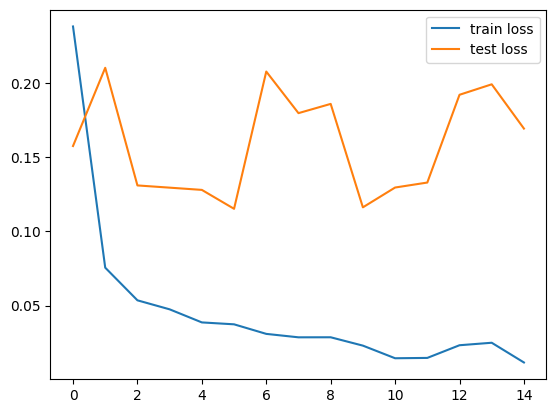

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

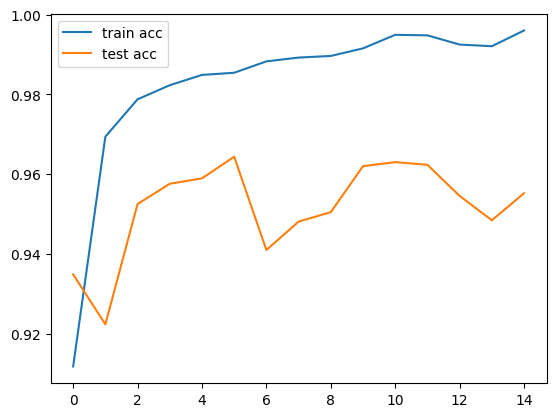

In [25]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [26]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [27]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

93/93 [==============================] - 0s 2ms/step


In [28]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9643705463182898